# dCas9 NOR-Gate

In [111]:
from IPython.display import display
import math
'''import piplite
await piplite.install("bqplot")
await piplite.install("ipywidgets")'''
import bqplot
from bqplot import pyplot as plt
import ipywidgets as widgets
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fsolve

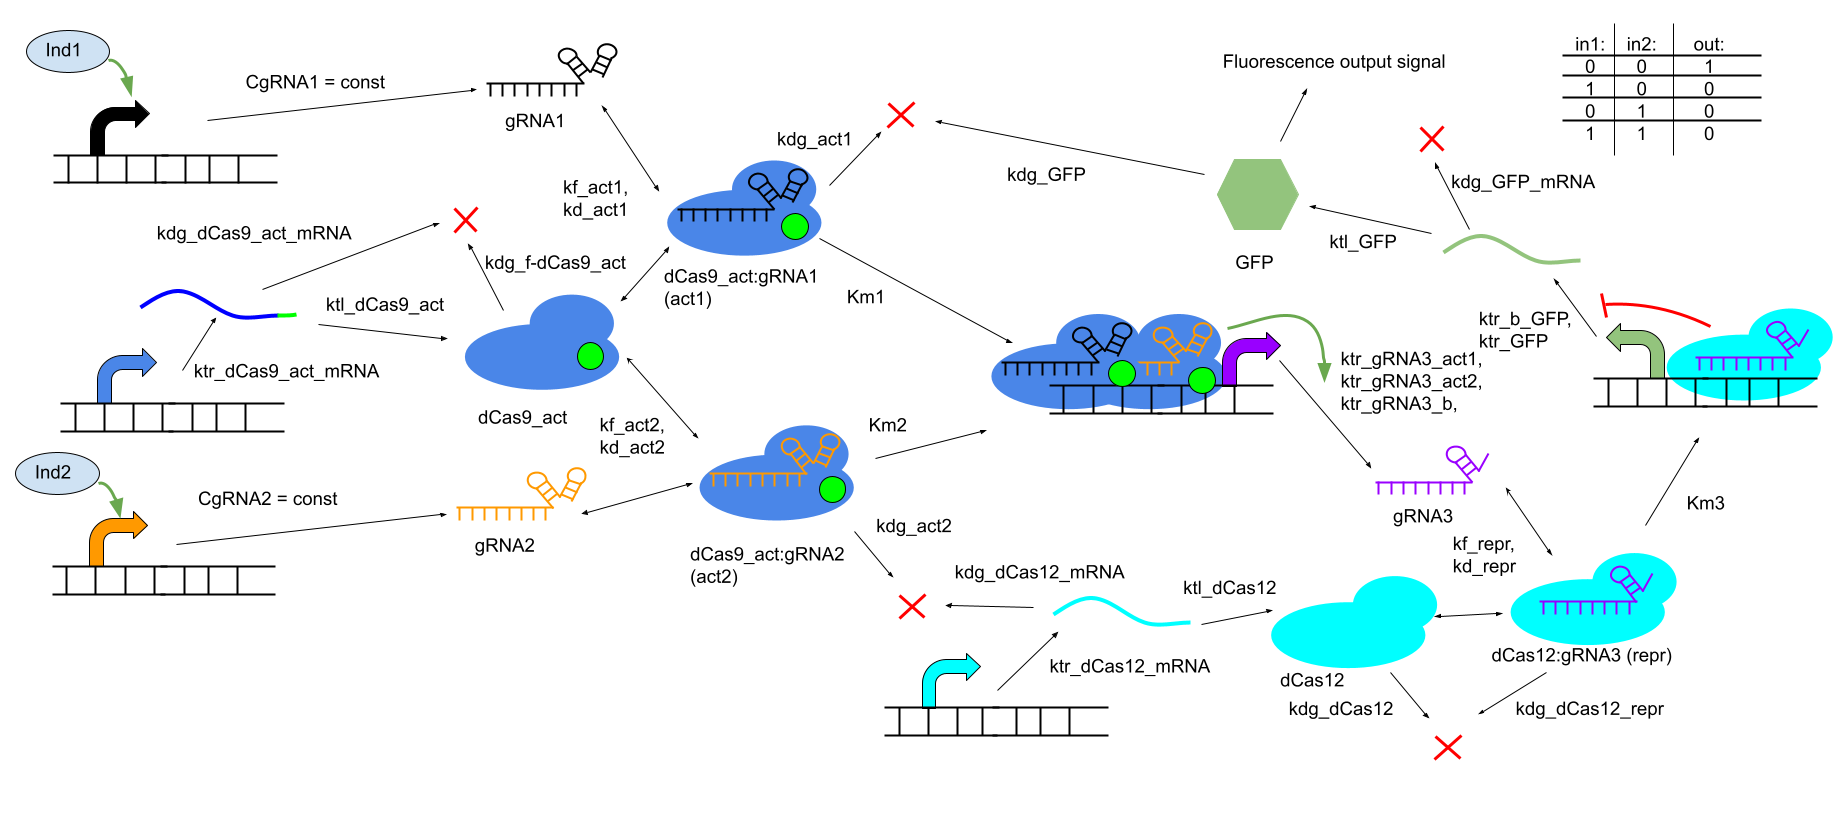

In [161]:
n = [0.9,0.9,0.9] #act1, act2, repr
#Np = 1 #number of plasmids
k1 = [0.6,0.3,0.3,29.97,2.99] #transcriprion rate mRNA_dCas9_act, sgRNA3 if act1, sgRNA3 if act 2, mRNA_dCas12, mRNA_GFP
k1b = [0.03,0.03] #basal transcriprion rate mRNA_dCas12, mRNA_GFP
Km = [0.12,0.12,0.0602] #act1, act2, repr
s = [0,0,0] #sgRNA1,sgRNA2, sgRNA3
m = [20,0,0] #dCas9_act, dCas12, GFP
p = [5,5,0,0,0,30] #dCas9_act, dCas12, act1, act2, repr, GFP
tau_mRNA = 2
tau_prot = 10
kd_m = [math.log(2)/tau_mRNA, math.log(2)/tau_mRNA, math.log(2)/(tau_mRNA*0.7)] #mRNA degradation (dCas9_act, dCas12, GFP)
kd_s = math.log(2)/(tau_mRNA*0.5) #sgRNA3 degradation
kd_p = [math.log(2)/tau_prot, math.log(2)/tau_prot, math.log(2)/(tau_prot+(0.2*tau_prot)), math.log(2)/(tau_prot+(0.2*tau_prot)), math.log(2)/(tau_prot*0.7)] #protein degradation (free dCas9_act, free dCas12, act1/act2, repr, GFP)
k_tl = [1.33,1.33,6.93] #dCas9_act,dCas12,GFP
k_f = [1,1,1]  #formation (act1, act2, repr)
k_d = [0.0602,0.0602,0.0602] #dissociation (act1, act2, repr)

In [162]:
def dCas_NOR_model(t, data, k1, k1b, Km, kd_m, kd_p, kd_s, k_f, k_d, k_tl, s, n):
    m = data[:3]
    s[2] = data[3]
    p = data[4:]
    dm0 = -kd_m[0]*m[0] + k1[0] #dCas9_act mRNA
    dm1 = -kd_m[1]*m[1] + k1[3] #dCas12 mRNA
    dm2 = -kd_m[2]*m[2] + (k1[4]*(Km[2]**n[2]))/((Km[2]**n[2])+(p[4]**n[2])) +  k1b[1] #GFP mRNA
    ds = -kd_s*s[2]  + (k1[1]*(p[2]**n[0]))/((Km[0]**n[0])+(p[2]**n[0])) + (k1[2]*(p[3]**n[1]))/((Km[1]**n[1])+(p[3]**n[1])) +  k1b[0] + k_d[2]*p[4] - k_f[2]*p[1]*s[2] #sgRNA3
    dp0 = -kd_p[0]*p[0] + k_tl[0]*m[0] + k_d[0]*p[2] - k_f[0]*p[0]*s[0] +  k_d[1]*p[3] - k_f[1]*p[0]*s[1] #free dCas9_act
    dp1 = -kd_p[1]*p[1] + k_tl[1]*m[1] + k_d[2]*p[4] - k_f[2]*p[1]*s[2] #free dCas12
    dp2 = -k_d[0]*p[2] + k_f[0]*p[0]*s[0] - kd_p[2]*p[2] #act1
    dp3 = -k_d[1]*p[3] + k_f[1]*p[0]*s[1] - kd_p[2]*p[3] #act2
    dp4 = -k_d[2]*p[4] + k_f[2]*p[1]*s[2] - kd_p[3]*p[4] #repr
    dp5 = -kd_p[4]*p[5] + k_tl[2]*m[2] #GFP
    return [dm0,dm1,dm2,ds,dp0,dp1,dp2,dp3,dp4,dp5]

In [163]:
t0 = 0.0
tf = 200.0
time = np.linspace(0.0,200.0,2000)
initval = np.array([*m,s[2],*p])
res = solve_ivp(dCas_NOR_model, (t0,tf), initval, method='RK45', t_eval=time, args=(k1,k1b,Km,kd_m,kd_p,kd_s,k_f,k_d,k_tl,s,n))
res = dict(res)
time = res['t'] 
y = res['y']
yGFP = y[9]


In [164]:
fig = plt.figure(title="dCas9 NOR-gate model", legend_location="top-left")
fig.layout.height = '500px'
fig.layout.width = '650px'

line_chart = plt.plot(x=time, y=yGFP, labels=["GFP"], colors=['green'],
                     display_legend=True)

plt.xlabel("Time, min")
plt.ylabel("Number of molecules")

In [165]:
def update_plot(tM, tP, tsg, CmRNAs, Cs, Cprots, n1, n2, n3):
    print('In progress...')
    s = [float(x) for x in Cs.split()]
    kd_m = [math.log(2)/float(x) for x in tM.split()]
    kd_p = [math.log(2)/float(x) for x in tP.split()]
    kd_s = math.log(2)/tsg
    m = [float(x) for x in CmRNAs.split()]
    p = [float(x) for x in Cprots.split()]
    n = [n1, n2, n3]
    t0 = 0.0
    tf = 200.0
    time = np.linspace(0.0,200.0,2000)
    initval = np.array([*m,s[2],*p])
    res = solve_ivp(dCas_NOR_model, (t0,tf), initval, method='RK45', t_eval=time, args=(k1,k1b,Km,kd_m,kd_p,kd_s,k_f,k_d,k_tl,s,n))
    res = dict(res)
    time = res['t'] 
    y = res['y']
    yGFP = y[9]
    line_chart.y = yGFP
    print('Finished')

In [166]:
#widgets
wdj = widgets.interactive(update_plot,
tM = widgets.Text(value=' '.join([str(tau_mRNA), str(tau_mRNA), str(tau_mRNA*0.7)]), description="t_mRNA_life:", disabled=False),                           
tP = widgets.Text(value=' '.join([str(tau_prot), str(tau_prot), str(tau_prot+(0.2*tau_prot)), str(tau_prot+(0.2*tau_prot)), str(tau_prot*0.7)]), description="t_protein_life:", disabled=False),
tsg = widgets.FloatText(value=tau_mRNA*0.5, description="t_sgRNA_life:", disabled=False),                          
CmRNAs = widgets.Text(value=' '.join([str(x) for x in m]), description="C_mRNAs:", disabled=False),
Cs = widgets.Text(value='0 0 0', description="C_sgRNAs:", disabled=False),
Cprots = widgets.Text(value=' '.join([str(x) for x in p]), description="C_proteins:", disabled=False),
n1 = widgets.FloatSlider(value=n[0], min=0.9, max=2.0, step=0.1, description="n1:", disabled=False),
n2 = widgets.FloatSlider(value=n[1], min=0.9, max=2.0, step=0.1, description="n2:", disabled=False),
n3 = widgets.FloatSlider(value=n[2], min=0.9, max=2.0, step=0.1, description="n3:", disabled=False))


In [167]:
"""res1 = solve_ivp(dCas_NOR_model, (t0,tf), initval, method='RK45', t_eval=time, args=(k1,k1b,Km,kd_m,kd_p,kd_s,k_f,k_d,k_tl,[0,1,0],n))
res1 = dict(res1)
time1 = res1['t'] 
y1 = res1['y']
yGFP1 = y1[9]
line_chart1 = plt.plot(x=time1, y=yGFP1, labels=["GFP"], colors=['red'],
                     display_legend=True)""" #если нужно сравнение

'res1 = solve_ivp(dCas_NOR_model, (t0,tf), initval, method=\'RK45\', t_eval=time, args=(k1,k1b,Km,kd_m,kd_p,kd_s,k_f,k_d,k_tl,[0,1,0],n))\nres1 = dict(res1)\ntime1 = res1[\'t\'] \ny1 = res1[\'y\']\nyGFP1 = y1[9]\nline_chart1 = plt.plot(x=time1, y=yGFP1, labels=["GFP"], colors=[\'red\'],\n                     display_legend=True)'

In [168]:
display(widgets.HBox([fig,wdj]))

In [169]:
fig2 = plt.figure(title="dCas9 NOR-gate model", legend_location="top-left")
fig.layout.height = '500px'
fig.layout.width = '650px'
s1 = [0,10,0] #sgRNA1,sgRNA2, sgRNA3
m1 = [20,0,0] #dCas9_act, dCas12, GFP
p1 = [5,5,0,0,0,30] #dCas9_act, dCas12, act1, act2, repr, GFP
initval1 = np.array([*m1,s1[2],*p1])
res2 = solve_ivp(dCas_NOR_model, (t0,tf), initval1, method='RK45', t_eval=time, args=(k1,k1b,Km,kd_m,kd_p,kd_s,k_f,k_d,k_tl,s1,n))
res2 = dict(res2)
time2 = res2['t'] 
y2 = res2['y']
ysgRNA = y2[3] + y2[8]
line_chart2 = plt.plot(x=time2, y=ysgRNA, labels=["sgRNA3"], colors=['red'], display_legend=True)
y3 = [s1[1]]*len(time)
line_chart3 = plt.plot(x=time2, y=y3, labels=["sgRNA2"], colors=['blue'],display_legend=True)

In [170]:
display(fig2)

Figure(axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top':…